In [14]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
from torchvision import models


from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
import gc; gc.enable() # memory is tight


import traceback
import torchvision
import os

import numpy as np # linear algebra
from sklearn.model_selection import train_test_split
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

from os.path import join
sys.path.append("../")
from src import utils
from src import ourmodels


gc.enable()
torch.backends.cudnn.benchmark=True


DATA = "../data/"
MODELS = "../models"

MODEL_CHECKPOINT = join(MODELS, "ResNetUnetv1_checkpoint/")
TRAINING_STATS = join(MODEL_CHECKPOINT, "progress.csv")
TRAINED_UNET_MODEL = join(MODEL_CHECKPOINT, "model.pt")
TRAIN_PROGRESS_IMAGES = join(MODEL_CHECKPOINT, "progress/")

SHIP_DIR = "/media/shivam/DATA/airbus-tracking/"
TRAIN_IMAGE_DIR = os.path.join(SHIP_DIR, "train_v2")
TEST_IMAGE_DIR = os.path.join(SHIP_DIR, "test_v2")

CSV_TRAIN = join(DATA, 'balanced_train_df_shipgt_4.csv')
CSV_VALID = join(DATA, 'balanced_valid_df_shipgt_4.csv')


TRAIN_BATCH = 1
VALID_BATCH = 1
TEST_BATCH = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset and preprocessing

In [2]:
class KaggleDataset(Dataset):
    def __init__(self, datapath, phase):
        self.data = pd.read_csv(datapath)
        self.phase = phase
        self.image_ids = np.unique(self.data['ImageId'])
        print("Unique images: {}".format(len(self.image_ids)))
            
    def __len__(self):
        return len(self.image_ids)
    
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(TRAIN_IMAGE_DIR, self.image_ids[idx])
        c_img = plt.imread(rgb_path)
        c_mask = utils.masks_as_image(self.data[self.data['ImageId'] == self.image_ids[idx]]['EncodedPixels'].tolist())
        
        c_img = np.stack(c_img, 0)/255.0
        c_mask = np.stack(c_mask, 0)
        if self.phase == 'train':
            crop_delta = 256
            factor = 5
            h, w, _ = c_mask.shape
            # Random crop selection trick
            x1 = np.random.randint(0, h-crop_delta)
            x2 = np.random.randint(0, w-crop_delta)
            c_mask = c_mask[x1:x1+crop_delta, x2:x2+crop_delta, :]
            c_img = c_img[x1:x1+crop_delta, x2:x2+crop_delta, :]
        
        c_img = c_img.transpose(-1, 0, 1)
        c_mask = c_mask.transpose(-1, 0, 1)
        return c_img.astype('f'), c_mask.astype('f')    
    

#     def item_as_image(self, items):
#         b = items.shape[0] if items.shape[0] > 0 else 1
#         for 
#         y_pred_tmp = y_pred[b, :, :, :].cpu().numpy().transpose(-1, 1, 0)[:, :, 0]

#         X_tmp = X[b, :, :, :].numpy().transpose(-1, 1, 0)

class Kaggle_Dataset_Test(Dataset):
    def __init__(self, testdir):
        self.testdir = testdir
        self.test_images = os.listdir(testdir)
        
    def __len__(self):
        return len(self.test_images)
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(self.testdir, self.test_images[idx])
        c_img = imread(rgb_path)
        c_img = np.stack(c_img, 0)/255.0
        c_img = c_img.transpose(-1, 0, 1)
        return self.test_images[idx], c_img.astype('f')

# Initializing for training

In [6]:
# Load in Dataset
trainDataset = KaggleDataset(CSV_TRAIN, 'train')
validDataset = KaggleDataset(CSV_VALID, 'valid')
testDataset = Kaggle_Dataset_Test(TEST_IMAGE_DIR)

Unique images: 4740
Unique images: 48


(3, 256, 256) (1, 256, 256)


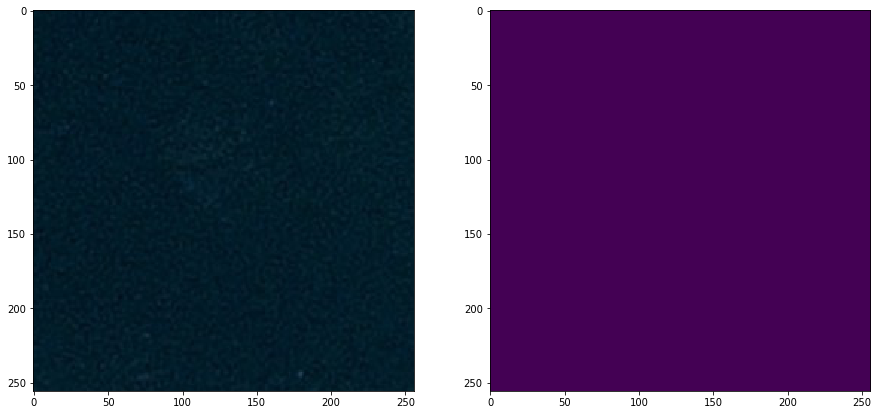

In [13]:
e = trainDataset[105]
utils.show(e[0], e[1])

# Training

In [15]:
# Construct UNet
gc.collect()
reuse = False

net = ourmodels.ResNetUnet(1)

# Load trained model if specified
if reuse:
    print("Reusing model from: {}".format(TRAINED_UNET_MODEL))
    net.load_state_dict(torch.load(TRAINED_UNET_MODEL))
    net.eval()
    
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
criterion = nn.BCELoss()

# Initialize train dataloader
trainDataLoader   = torch.utils.data.DataLoader(
        trainDataset
        , batch_size=TRAIN_BATCH,shuffle=True
        , num_workers=1, pin_memory=True)

# Initialize validation dataloader
validDataLoader   = torch.utils.data.DataLoader(
        validDataset
        , batch_size=VALID_BATCH,shuffle=False
        , num_workers=0, pin_memory=True)

In [16]:
from src.main import DeepLearning

model = DeepLearning(net, criterion, MODEL_CHECKPOINT)
model.fit(trainDataLoader, 10, optimizer, validDataLoader, cuda=False)

Training has begun ...
Training in epoch: 1


/home/shivam/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/shivam/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Process Process-9:
Traceback (most recent call last):
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shivam/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(t

KeyboardInterrupt: 

In [11]:
train(net, criterion, optimizer, 100, trainDataLoader, validDataLoader, cuda = False)

Training has begun ...
Training in epoch: 1


/home/shivam/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 14 and 13 in dimension 2 at /opt/conda/conda-bld/pytorch_1533672544752/work/aten/src/TH/generic/THTensorMath.cpp:3616

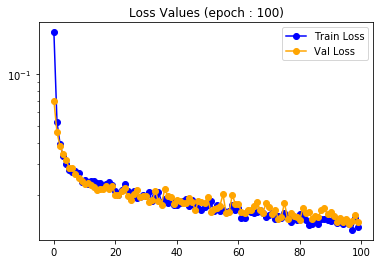

In [11]:
training_stats = pd.read_csv(TRAINING_STATS)
plt.plot(range(100), np.array(training_stats)[:, 0], color='blue', marker='o', label='Train Loss', )
plt.plot(range(100), np.array(training_stats)[:, 1], color='orange', marker='o', label='Val Loss')
plt.yscale('log')
plt.title('Loss Values (epoch : {0})'.format(100))
plt.legend()
plt.show()

# Inference

In [6]:
# Encoding functions for found masks
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


#Load testing images
testDataLoader   = torch.utils.data.DataLoader(
        testDataset
        , batch_size=TEST_BATCH,shuffle=False
        , num_workers=4, pin_memory=True)
print("Number of test images found: {}".format(len(testDataLoader)))

# Load inference model
net = UNet(3, 1).cuda()
net.load_state_dict(torch.load(TRAINED_UNET_MODEL))
net.eval()
clear_output()

In [7]:
from skimage.morphology import label
out_pred_rows = []
with torch.no_grad():
    for i, data in tqdm_notebook(enumerate(testDataLoader), total=len(testDataLoader)):
        c_img_name, X = data
        y_pred = net(X.cuda())

        for b in range(y_pred.shape[0]):
            y_pred_tmp = y_pred[b, :, :, :].cpu().numpy().transpose(-1, 1, 0)
            y_pred_tmp[y_pred_tmp >= 0.5] = 1
            y_pred_tmp[y_pred_tmp < 0.5] = 0

            cur_rles = multi_rle_encode(y_pred_tmp)
            if len(cur_rles)>0:
                for c_rle in cur_rles:
                    out_pred_rows += [{'ImageId': c_img_name[b], 'EncodedPixels': c_rle}]
            else:
                out_pred_rows += [{'ImageId': c_img_name[b], 'EncodedPixels': None}]
            gc.collect()

/home/shivam/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [8]:
len(out_pred_rows)

29418

In [9]:
# Save dataframe to submission file.
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(3)

,ImageId,EncodedPixels
15088,2c493e3c4.jpg,463224 1
24535,8a192188d.jpg,None
11958,8b7e519f9.jpg,139242 2 140011 1 140772 10 141541 10 142312 5


# Rough

In [ ]:
class KaggleDataset(Dataset):
    
    def __init__(self, ship_dir):
        self.ship_dir = ship_dir
        self.train_image_dir = os.path.join(self.ship_dir, 'train_v2')
        self.test_image_dir = os.path.join(self.ship_dir, 'test_v2')
        print("Starting preprocess")
        self.preprocess_pickle()
        
    def preprocess_pickle(self):
        with open('all_batches_balancedTrain.pickle', 'rb') as f:
            self.all_batches_balancedTrain = pickle.load(f)
        with open('all_batches_balancedValid.pickle', 'rb') as f:
            self.all_batches_balancedValid = pickle.load(f)

    def preprocess(self):
        
        def sample_ships(in_df, base_rep_val=1500):
            if in_df['ships'].values[0]==0:
                return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
            else:
                return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
        masks = pd.read_csv(os.path.join(self.ship_dir, 'train_ship_segmentations_v2.csv'))
        
        masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
        unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
        print("Reach 1")
        unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
        unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
        # some files are too small/corrupt
        print("Reach 1.2")
        unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                                       os.stat(os.path.join(self.train_image_dir, 
                                                                                            c_img_id)).st_size/1024)
        print("Reach 2")
        unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
        masks.drop(['ships'], axis=1, inplace=True)
        train_ids, valid_ids = train_test_split(unique_img_ids, 
                         test_size = 0.3, 
                         stratify = unique_img_ids['ships'])
        
        
        print("Reach 3")
        train_df = pd.merge(masks, train_ids)
        valid_df = pd.merge(masks, valid_ids)
        train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)

        
        print("Reach 4")
        balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
        print("Creating list")
        self.all_batches_balancedTrain = list(balanced_train_df.groupby('ImageId'))
        self.all_batches_balancedValid = list(valid_df.groupby('ImageId'))
        
        with open('all_batches_balancedTrain.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.all_batches_balancedTrain, f, pickle.HIGHEST_PROTOCOL)

        with open('all_batches_balancedValid.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.all_batches_balancedValid, f, pickle.HIGHEST_PROTOCOL)
            
    def __len__(self):
        return len(self.all_batches_balancedTrain)
    
    def multi_rle_encode(self, img):
        labels = label(img[:, :, 0])
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

    # ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
    def rle_encode(self, img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def rle_decode(self, mask_rle, shape=(768, 768)):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, 1 - mask, 0 - background
        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).T  # Needed to align to RLE direction

    def masks_as_image(self, in_mask_list):
        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768), dtype = np.int16)
        #if isinstance(in_mask_list, list):
        for mask in in_mask_list:
            if isinstance(mask, str):
                all_masks += self.rle_decode(mask)
        return np.expand_dims(all_masks, -1)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.train_image_dir, self.all_batches_balancedTrain[idx][0])
        c_img = imread(rgb_path)
        c_mask = self.masks_as_image( self.all_batches_balancedTrain[idx][1]['EncodedPixels'].values)
        
        c_img = np.stack(c_img, 0)/255.0
        c_mask = np.stack(c_mask, 0)
        
        c_img = resize(c_img, (c_img.shape[0] / 2, c_img.shape[1] / 2),
                       anti_aliasing=True)
        
        c_mask = resize(c_mask, (c_mask.shape[0] / 2, c_mask.shape[1] / 2),
                       anti_aliasing=True)
        
        c_img = c_img.transpose(-1, 0, 1)
        c_mask = c_mask.transpose(-1, 0, 1)
        
        
        return c_img, c_mask

    def show(self, x, y):
        f, axarr = plt.subplots(1,2, figsize=(15, 15))

        axarr[0].imshow(x.transpose(-1, 1, 0))
        axarr[1].imshow(y.transpose(-1, 1, 0)[:, :, 0])
            

if(10):
    ship_dir = '/media/shivam/DATA/airbus-tracking/'
    trainDataset = KaggleDataset(ship_dir)

In [ ]:

# # x, y = trainDataset[1]

# # yp = np.ones_like(y)
y = torch.from_numpy(np.random.random((4, 1, 153, 153)))
y = torch.from_numpy(np.random.random((4, 1, 153, 153)))
yp = torch.from_numpy(np.random.random((4, 1, 153, 153)))

# print(dice_coeff(y, yp))

In [ ]:
idx = np.random.randint(0,len(trainDataset.all_batches_balancedTrain))
# idx = 57
factor = 5
print(idx)

rgb_path = os.path.join(trainDataset.train_image_dir, trainDataset.all_batches_balancedTrain[idx][0])
c_img = imread(rgb_path)
c_mask = trainDataset.masks_as_image( trainDataset.all_batches_balancedTrain[idx][1]['EncodedPixels'].values)



h, w, _ = c_mask.shape
c = 192

x1 = np.random.randint(0, h-c)
x2 = np.random.randint(0, w-c)

c_img_s = c_img[x1:x1+c, x2:x2+c, :]
c_mask_s = c_mask[x1:x1+c, x2:x2+c, :]

# c_img_s = resize(c_img, (c_img.shape[0] // factor, c_img.shape[1] // factor), anti_aliasing=False)
# c_mask_s = img_as_bool(resize(c_mask, (c_mask.shape[0] // factor, c_mask.shape[1] // factor), anti_aliasing=False))
# c_mask_s = resize(c_mask, (c_mask.shape[0] // factor, c_mask.shape[1] // factor), anti_aliasing=False)

# c_mask_s = resize(c_mask, (c_mask.shape[0] // factor, c_mask.shape[1] // factor), anti_aliasing=False)
# c_mask_s[c_mask_s < 0.5] = 0
# c_mask_s[c_mask_s >= 0.5] = 1

# from torchvision.transforms import RandomCrop

# func = RandomCrop(192)

# c_mask_s = func(torch.from_numpy(c_mask))

print(np.sum(c_mask_s))
# print(c_img.shape, c_mask.shape)
# print(c_img_s.shape, c_mask_s.shape)
f, axarr = plt.subplots(2,2, figsize=(15,15))
axarr[0][0].imshow(c_img)
axarr[0][1].imshow(c_mask[:,:,0])
axarr[1][0].imshow(c_img_s)
axarr[1][1].imshow(c_mask_s[:,:,0])

# print (trainDataset.all_batches_balancedTrain[idx][1])